# Introduction

Welcome to our end-to-end example of Passport Data Extraction with Face Segment Output. In this demo, we will demonstrate how to use this sagemaker model for passport data extraction, and face segment output. 

# Prequisites and Preprocessing

## Creating the endpoint with subscribed image

Before you start, you should already subscribe to [our model package](https://aws.amazon.com/marketplace/pp/prodview-g7oabg64r5vui) from AWS Marketplace. Upon a successful 
Under your AWS account's AWS Marketplace subscriptions, you will see 'Passport Verification' is shown there. By clicking this subscribed model packages, you will be able to create the endpoint/create the model like below, by selecting the model package and click 'actions' -> 'create endpoint'.

![Endpoint Creation Guide](doc_image/sagemaker-endpoint-creating.png)

Inside create endpoint menu, you could name the endpoint as you wish, and record the endpoint name for reference purpose. Next, we would show you how to encode your image and use the endpoint.

## Preparing the image and encoding the image
Let's use this sample image as an example. You may find this image in the sample image folder in our [github repository](https://github.com/gtriip/sagemaker-sample-inference-notebook.git).
Basically, the requirement to the images are:
1. Clear enough so that MRZ code are visible;
2. Passport should be the main object in the image, occupying the most space;
3. Image should have a clear background, especially need to be clear from other text in the background, else the model would fail in locating the location of MRZ;
4. Whether the passport is half (only biodata page) or full doesn't matter.

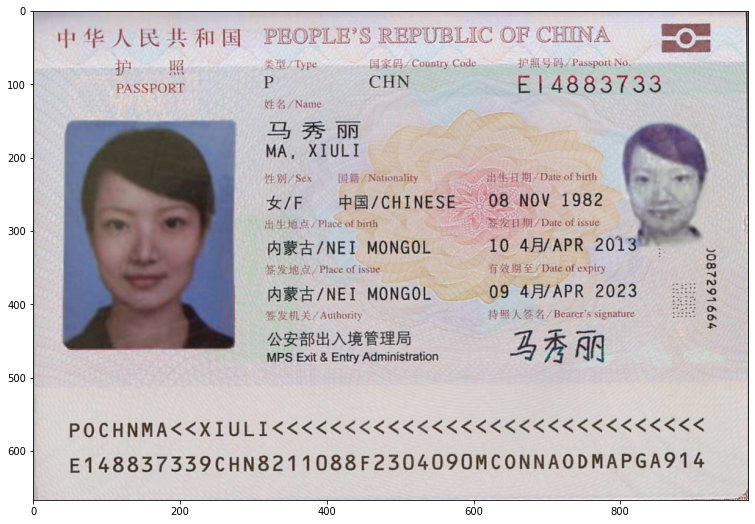

In [1]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# For better displaying...
plt.rcParams["figure.figsize"] = (16, 9)

# Specify the image path
image_path = 'sample_image/passport_34.png'

# Read image, and change colorspace for showing
passport_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
passport_image = cv2.cvtColor(passport_image, cv2.COLOR_BGR2RGB)

# Display using pyplot
img_plot = plt.imshow(passport_image)

Next, we would encode it in base64 format, and wrap this request into a JSON file format for requesting.

In [2]:
import base64
import json

# Encode the image file data
with open(image_path, 'rb') as image_file:
    image_bytes = image_file.read()

image_bytes_encoded = base64.b64encode(image_bytes)

# Wrap in JSON format to pass to the engine. 
# Because JSON requires non-bytes, we would need to decode it again using 'utf-8'
request_dict = {"image": image_bytes_encoded.decode('utf-8')}
request_json = json.dumps(request_dict, indent=4)

With this preparation of image done, we can launch the request in the next step.

# Requesting and Result Handling

With the endpoint created in your aws account, and you setup the credentials in `/.aws/` folder properly, you could easily launch requests using the following block of code:

In [3]:
import boto3

client = boto3.client('sagemaker-runtime')

# Your endpoint name
endpoint_name = "passport-verification-endpoint"
# content_type and accept MIME type are both "application/json"
content_type = "application/json"
accept = "application/json"
payload = request_json

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type, 
    Accept=accept, 
    Body=payload
)

print(response)

{'ResponseMetadata': {'RequestId': '202b131a-826e-4dbe-ba7a-db126e4bbef4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '202b131a-826e-4dbe-ba7a-db126e4bbef4', 'x-amzn-invoked-production-variant': 'variant-name-1', 'date': 'Tue, 19 Jul 2022 10:02:46 GMT', 'content-type': 'application/json', 'content-length': '645'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'variant-name-1', 'Body': <botocore.response.StreamingBody object at 0x7f8285ca6ac0>}


We successfully get response from the server. Next, we'll use json.loads to read the result back into a dictionary, and we would be able to use the corresponding results afterwards.

In [4]:
import pprint
pprinter = pprint.PrettyPrinter(indent=0)
result_content = json.loads(response['Body'].read().decode('utf-8'))
pprinter.pprint(result_content)

{'error_code': '-1',
'error_message': '',
'result': {'check_composite': '4',
          'check_date_of_birth': '8',
          'check_expiration_date': '0',
          'check_number': '9',
          'check_personal_number': '1',
          'country': 'China',
          'date_of_birth': '1982-11-08',
          'document_type': 'passport',
          'expiration_date': '2023-04-09',
          'expired': False,
          'face_location': [74, 225, 149, 185],
          'first_name': 'XIULI',
          'last_name': 'MA',
          'mrz_type': 'TD3',
          'nationality': 'CHN',
          'number': 'E14883733',
          'personal_number': 'MCONNAODMAPGA9',
          'sex': 'Female',
          'type': 'PO',
          'valid_composite': True,
          'valid_date_of_birth': True,
          'valid_expiration_date': True,
          'valid_number': True,
          'valid_personal_number': True,
          'valid_score': 100},
'success': True}


You could then refer to the valid_score as a reference of the recognition quality, rejecting a recognition when it's lower than your threshold in case an unwanted result is reached in the end. Next, let's see how should we use the returned face_location.

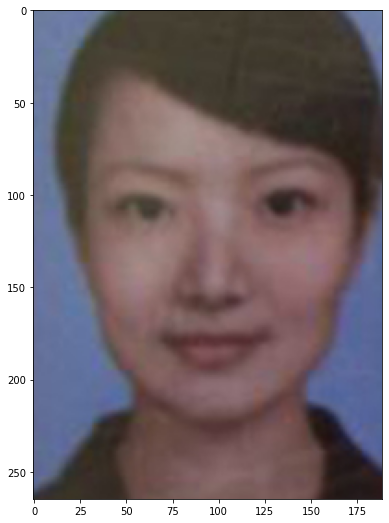

In [5]:
face_location = result_content['result']['face_location']

# The face_location field is arrange in format of [x, y, w, h], so we could access it using list comprehension
# As an example:
x, y, w, h = face_location
# You could add some bleeding to make the result look more holistic
face_roi = passport_image[y-40: y+h+40, x-20: x+w+20]

# Display using pyplot
img_plot = plt.imshow(face_roi)

# Error Code and Message Mapping

In the case of a failed recognition, different types of error message and error codes would be returned. Let's try a failed case (passport image with no face) for a basic understanding.

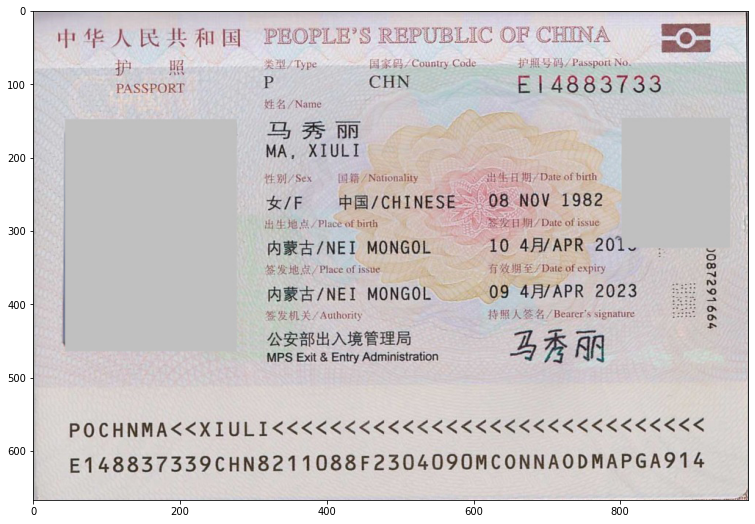

In [6]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# For better displaying...
plt.rcParams["figure.figsize"] = (16, 9)

# Specify the image path
image_path = 'sample_image/passport_34_no_face.png'

# Read image, and change colorspace for showing
passport_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
passport_image = cv2.cvtColor(passport_image, cv2.COLOR_BGR2RGB)

# Display using pyplot
img_plot = plt.imshow(passport_image)

In [7]:
import base64
import json

# Encode the image file data
with open(image_path, 'rb') as image_file:
    image_bytes = image_file.read()

image_bytes_encoded = base64.b64encode(image_bytes)

# Wrap in JSON format to pass to the engine. 
# Because JSON requires non-bytes, we would need to decode it again using 'utf-8'
request_dict = {"image": image_bytes_encoded.decode('utf-8')}
request_json = json.dumps(request_dict, indent=4)

In [8]:
import boto3

client = boto3.client('sagemaker-runtime')

# Your endpoint name
endpoint_name = "passport-verification-endpoint"
# content_type and accept MIME type are both "application/json"
content_type = "application/json"
accept = "application/json"
payload = request_json

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type, 
    Accept=accept, 
    Body=payload
)

print(response)

{'ResponseMetadata': {'RequestId': '58b6714c-f6f5-4631-b306-d6c7ab26ee9e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '58b6714c-f6f5-4631-b306-d6c7ab26ee9e', 'x-amzn-invoked-production-variant': 'variant-name-1', 'date': 'Tue, 19 Jul 2022 10:02:50 GMT', 'content-type': 'application/json', 'content-length': '109'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'variant-name-1', 'Body': <botocore.response.StreamingBody object at 0x7f8285c33a30>}


In [9]:
import pprint
pprinter = pprint.PrettyPrinter(indent=0)
result_content = json.loads(response['Body'].read().decode('utf-8'))
pprinter.pprint(result_content)

{'error_code': '005',
'error_message': 'Face not found, invalid passport document.',
'result': '',
'success': False}


You could see it's `error_code` 005, with `error_message` Face not found, invalid passport document. The mapping of all `error_code` and `error_message` can be find in the following table:

| error_code | error_message | condition |
|---|---|---|
| 001 | Wrong request format, please refer to the documents. | When 'image' not in the request dictionary. Please double check your request. |
| 002 | Image file size is too big for this engine, please resize first. | This is legacy, now when the model receive an image that's too big, it would auto-resize. |
| 003 | Image reading error, please check if it is encoded correctly. | This happens when the image is not properly base64 encoded. Please refer to the encoding section. |
| 004 | Error reading the image, please check the documents and report this error to us. | A general exception when image fails to read. Please reflect to us when this happens. |
| 005 | Face not found, invalid passport document. | When no face, or too small a face is detected in the passport document image. |
| 006 | Passport recognition failure. | A general failure in recognition, mainly a server internal error. |
| 007 | MRZ invalid, consider as a failed recognition. | When the valid score is smaller than 40, or the MRZ is of a wrong type, this error would occur. |
| 008 | MRZ not found, please consider another cropping and remove the background noise. | When no MRZ is found in the image, this error would occur. Please try to clear the image background and try again. |
| -1 |  | successful recognition |

In the case that more help and explanation is needed, please contact Frosty at [Frosty](mailto:frosty@gtriipglobal.com)